<a href="https://colab.research.google.com/github/XtremeQuantLeap/Bollinger-Bands-for-TSLA/blob/main/SABR_Volatility_Model_and_its_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysabr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 24.8 MB/s eta 0:00:00


IMPLEMENTING SABR VOLATILITY MODEL AND CALIBRATION

SABR MODEL. The SABR Model is a Stochastic Volatility Model, which attempts to capture the Volatility Smile in Derivative Markets. SABR stands for Stochastic Alpha, Beta, Rho, referring to the parameters of the model. SABR Model is widely used in the Interest Rate Derivative Markets.
SABR Model is used to model Forward Libor Rate, a Forward Swap Rate, a Forward Index Price. It’s an extension of Black’s Model. SABR Model is not a pure option pricing model, it’s a Stochastic Volatility Model. However, SABR Model does not calculates option options prices directly. Rather, it calculates an estimate of the Implied Volatility Curve, which is subsequently used as an input in Black’s Model to price Swaptions, Caps and other Interest Rate Derivatives.
We use a Swaption Data Base to compare both functions: Hagan2002NormalSABR and Hagan2022LognormalSABR.
In order to calibrate the SABR Model we need Strikes and Log Normal Vols Data.


In [ ]:
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import pysabr
from pysabr import Hagan2002LognormalSABR
import itertools
# Import both Lognormal and Normal SABR model classes
from pysabr import Hagan2002NormalSABR
from pysabr.helpers import year_frac_from_maturity_label
import pandas as pd
import numpy as np
plt.rcParams['figure.figsize']=(15,5)

In [ ]:
sabrLognormal = Hagan2002LognormalSABR(f=2.5271/100, shift=3/100, t=10, beta=0.5)
strikes = np.array([-0.4729, 0.5271, 1.0271, 1.5271, 1.7771, 2.0271, 2.2771, 2.4021,
              2.5271, 2.6521, 2.7771, 3.0271, 3.2771, 3.5271, 4.0271, 4.5271,
              5.5271]) / 100
LogNormalVols = np.array([19.641923, 15.785344, 14.305103, 13.073869, 12.550007, 12.088721,
              11.691661, 11.517660, 11.360133, 11.219058, 11.094293, 10.892464,
              10.750834, 10.663653, 10.623862, 10.714479, 11.103755])

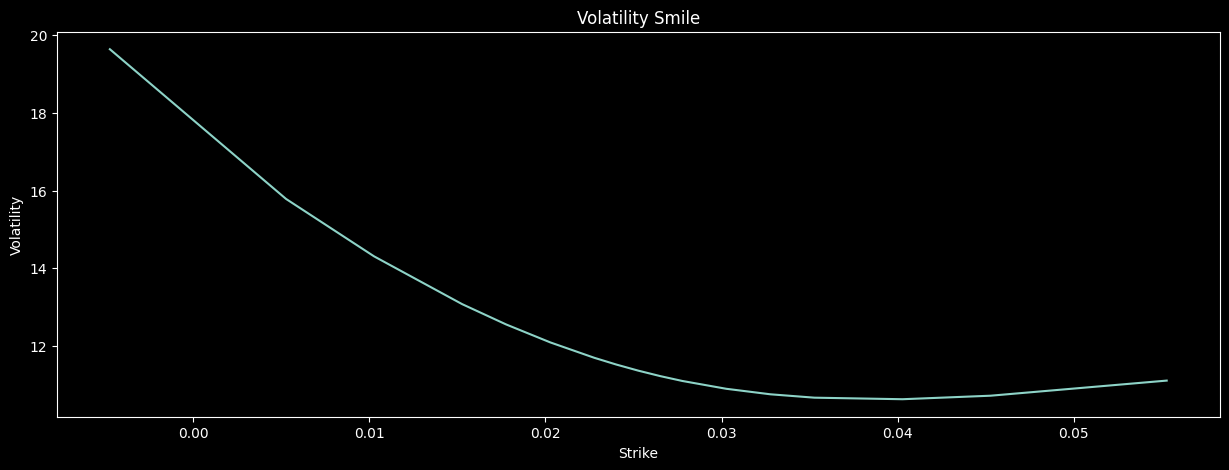

Fitted  alpha, rho, volvol:  [0.02529998154374072, -0.2462991763735908, 0.2908005625738888]


In [ ]:
plt.xlabel('Strike')
plt.ylabel('Volatility')
plt.title("Volatility Smile")
plt.plot(strikes, LogNormalVols)
plt.show()
[alpha, rho1, volvol1] = sabrLognormal.fit(strikes, LogNormalVols)
print("Fitted  alpha, rho, volvol: ", [alpha, rho1, volvol1])

In [ ]:
df = pd.read_csv('vols.csv')
df.set_index(['Type', 'Option_expiry'], inplace=True)
df.sort_index(inplace=True)
idx = pd.IndexSlice
print(df.loc[idx[:, '1Y'], '10Y'])

Type            Option_expiry
Beta            1Y                0.500000
Forward         1Y                2.536488
Normal_ATM_vol  1Y               59.240000
Rho             1Y               -0.070000
Shift           1Y                2.000000
Volvol          1Y                0.500000
Name: 10Y, dtype: float64


Swaption Grid:  [('1M', '2Y'), ('1M', '10Y'), ('1M', '30Y'), ('1Y', '2Y'), ('1Y', '10Y'), ('1Y', '30Y'), ('10Y', '2Y'), ('10Y', '10Y'), ('10Y', '30Y')]
Strikes:  [-1.         -0.92929293 -0.85858586 -0.78787879 -0.71717172 -0.64646465
 -0.57575758 -0.50505051 -0.43434343 -0.36363636 -0.29292929 -0.22222222
 -0.15151515 -0.08080808 -0.01010101  0.06060606  0.13131313  0.2020202
  0.27272727  0.34343434  0.41414141  0.48484848  0.55555556  0.62626263
  0.6969697   0.76767677  0.83838384  0.90909091  0.97979798  1.05050505
  1.12121212  1.19191919  1.26262626  1.33333333  1.4040404   1.47474747
  1.54545455  1.61616162  1.68686869  1.75757576  1.82828283  1.8989899
  1.96969697  2.04040404  2.11111111  2.18181818  2.25252525  2.32323232
  2.39393939  2.46464646  2.53535354  2.60606061  2.67676768  2.74747475
  2.81818182  2.88888889  2.95959596  3.03030303  3.1010101   3.17171717
  3.24242424  3.31313131  3.38383838  3.45454545  3.52525253  3.5959596
  3.66666667  3.73737374  3.80808081  

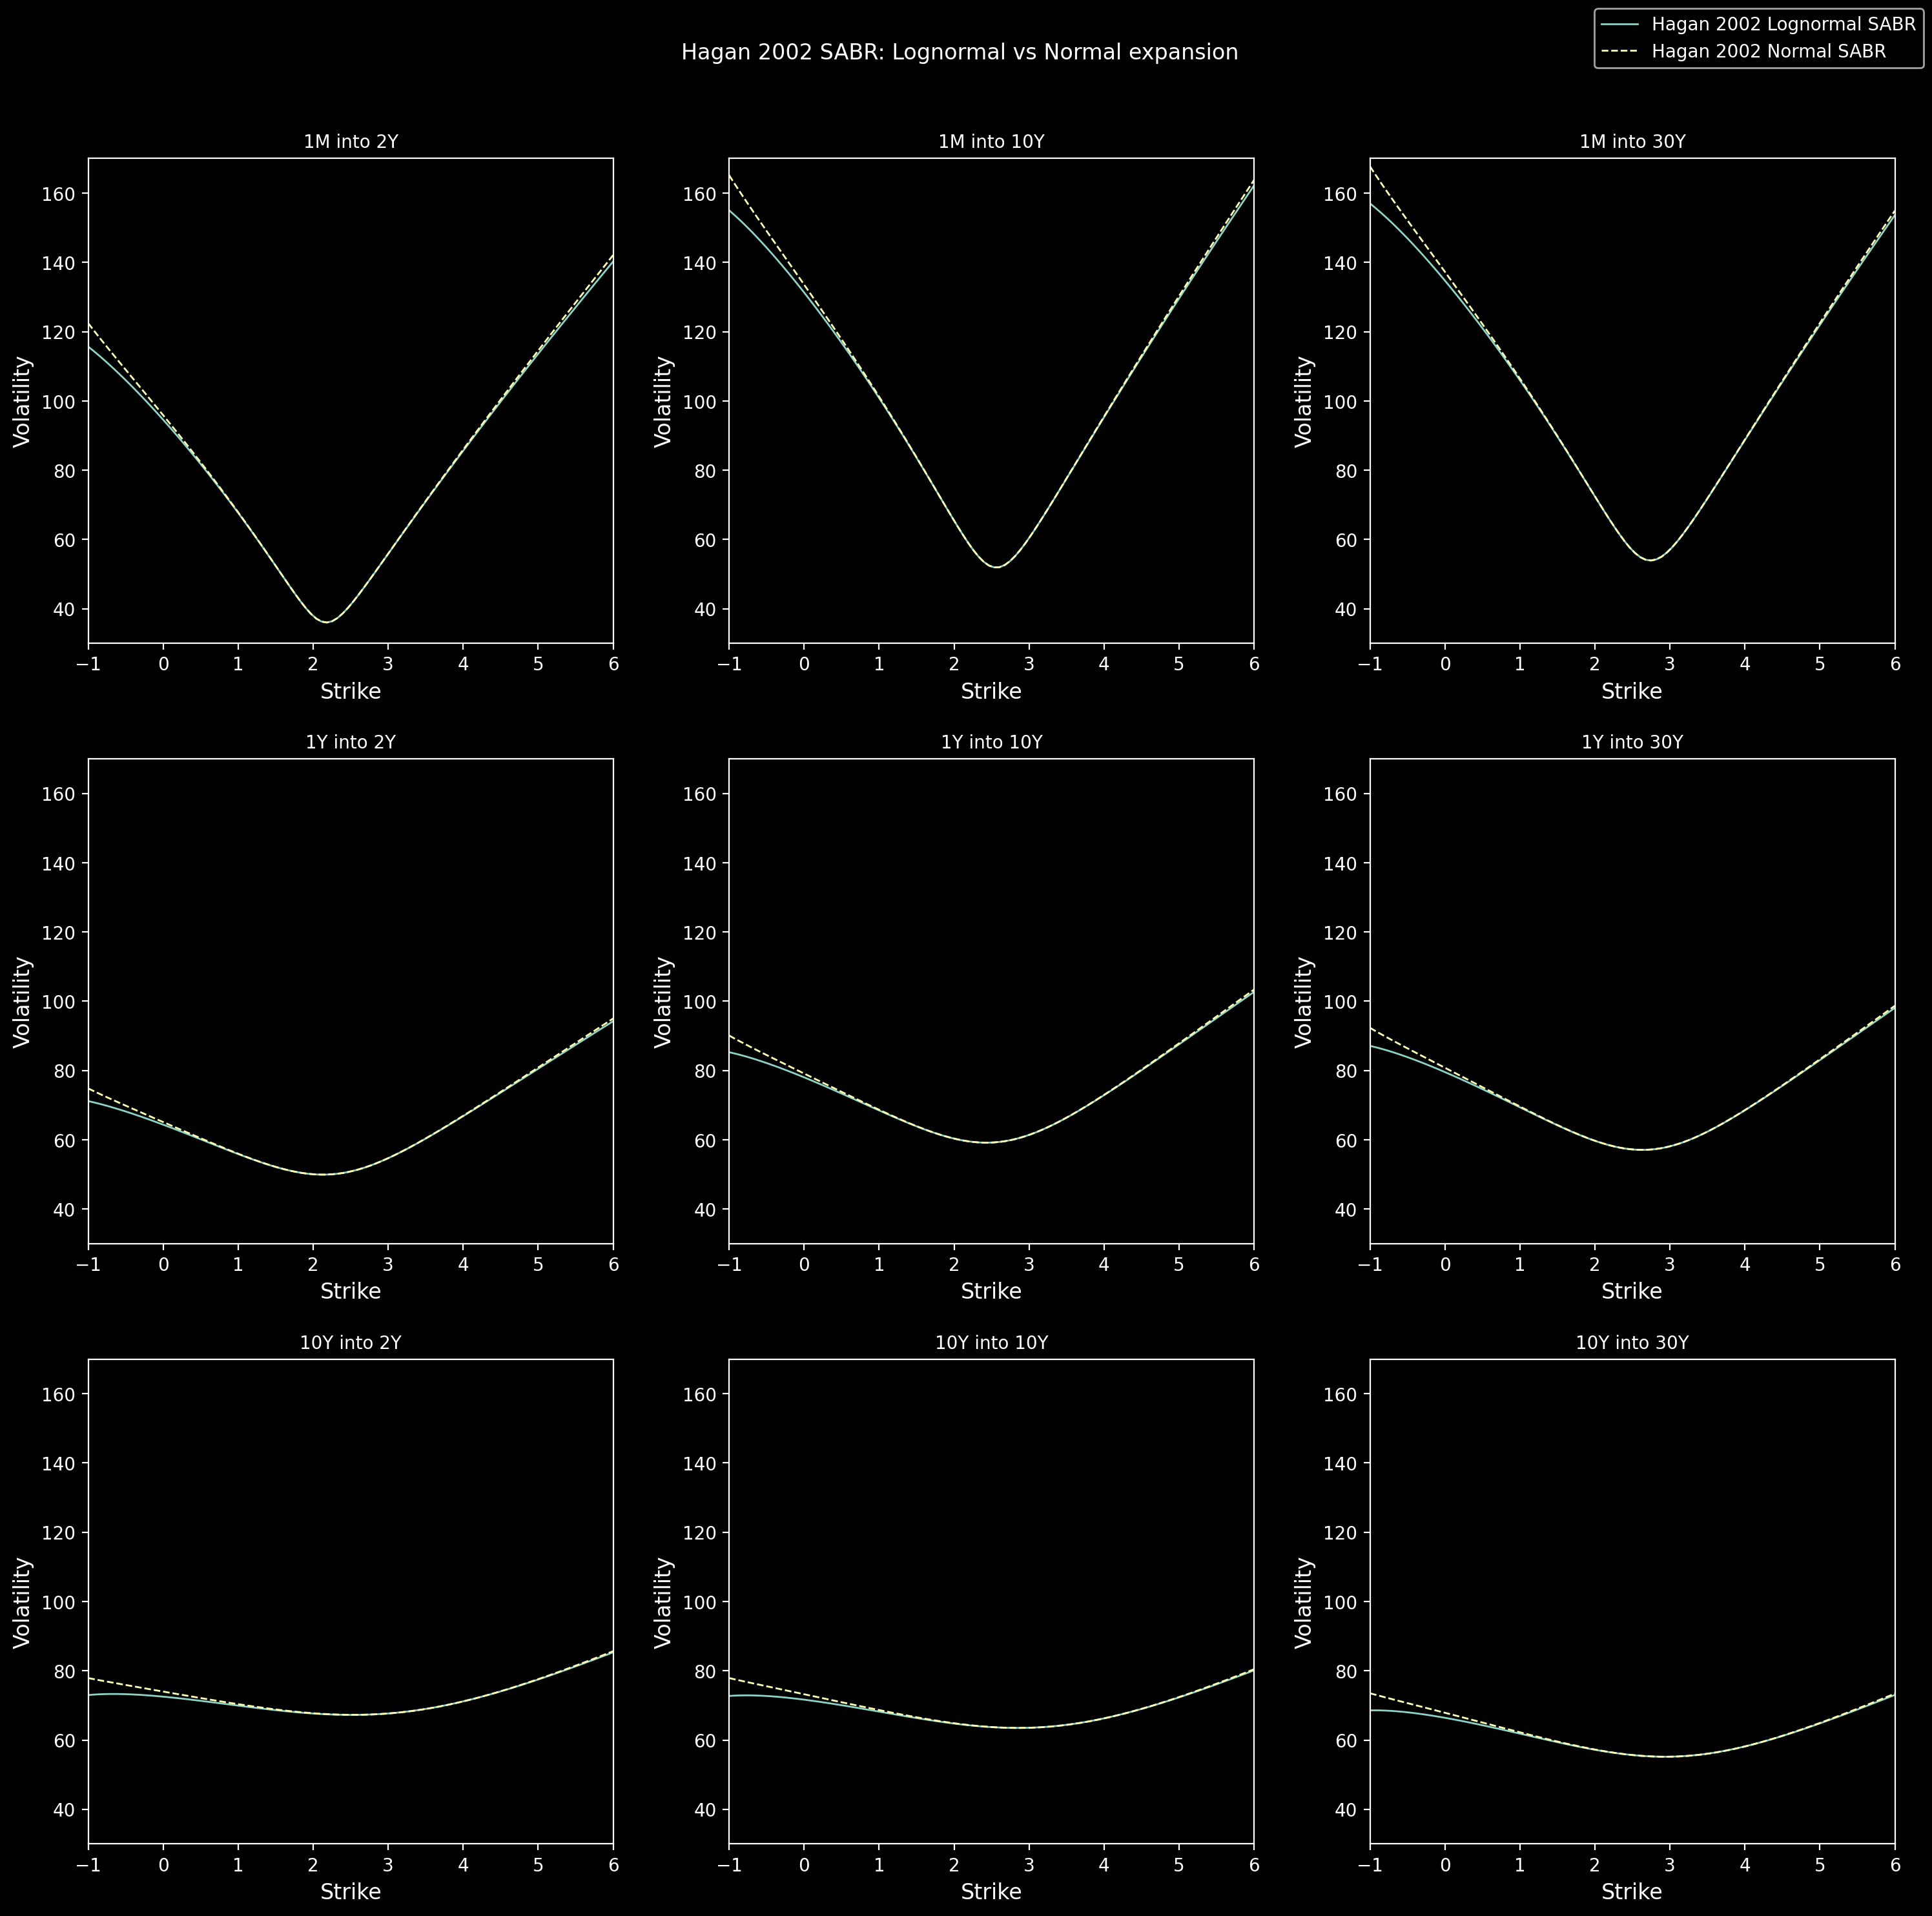

In [ ]:
option_expiries = ['1M', '1Y', '10Y']
swap_tenors = ['2Y', '10Y', '30Y']
m = len(option_expiries); n = len(swap_tenors)
swaption_grid = list(itertools.product(*[option_expiries, swap_tenors]))
print("Swaption Grid: ", swaption_grid)
n_strikes = 100
strikes = np.linspace(-1.00, 6.00, n_strikes)
print("Strikes: ", strikes)
fig, axes = plt.subplots(m, n)
fig.set_dpi(200)
fig.set_size_inches((15, 15))
fig.tight_layout(w_pad=3.5, h_pad=5.0)

for ((option_expiry, swap_tenor), ax) in zip(swaption_grid, fig.get_axes()):
    beta, f, v_atm_n, rho, shift, volvol = list(df.loc[idx[:, option_expiry], swap_tenor].reset_index(level=1, drop=True))

    t = year_frac_from_maturity_label(option_expiry)
    sabr_ln = Hagan2002LognormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_n = Hagan2002NormalSABR(f/100, shift/100, t, v_atm_n/1e4, beta, rho, volvol)
    sabr_ln_vols = [sabr_ln.normal_vol(k/100) * 1e4 for k in strikes]
    sabr_n_vols = [sabr_n.normal_vol(k/100) * 1e4 for k in strikes]
    ax.plot(strikes, sabr_ln_vols, linewidth=1.0, linestyle='-')
    ax.plot(strikes, sabr_n_vols, linewidth=1.0, linestyle='--')
    ax.set_xlim((-1.0, 6.0))
    ax.set_ylim((30., 170.))
    ax.set_xlabel('Strike', fontsize=12)
    ax.set_ylabel('Volatility', fontsize=12)
    ax.set_title("{} into {}".format(option_expiry, swap_tenor), fontsize=10)

line_sabr_ln = axes[0][0].get_lines()[0]
line_sabr_n = axes[0][0].get_lines()[1]
fig.legend(handles=(line_sabr_ln, line_sabr_n), labels=('Hagan 2002 Lognormal SABR', 'Hagan 2002 Normal SABR'), loc='upper right')
fig.suptitle("Hagan 2002 SABR: Lognormal vs Normal expansion", fontsize=12)
fig.subplots_adjust(left=0.05, top=0.92, bottom=0.05)
fig.savefig("Lognormal SABR vs Normal SABR.pdf", format='pdf')